# Generative Adverarial Networks
In GANs, we have two neural networks. One network is known as the **generator** which generates data based on a model it has created using samples of real data it has received as input. 

The other network is known as the **discriminator** which discriminates between the data created by the generator and data from the true distribution. 

The generator can be seen as the *counterfeiter*, and the discriminator is the *police* trying to identify the forgery. 

The two networks are locked in a **zero-sum game**. 

The generator is trying to fool the discriminator into thinking the synthetic data comes from the true distribution, and the discriminator is trying to call out the synthetic data as fake. 

GANs are unsuperbised learning algorithms because the generator can learn the underlying structure of the true distribution even when there are no labels. 

The generator learns the underlying structure by using a number of parameters significantly smaller than the amount of data it has trained on.

The **constraint** forces the generator to efficiently capture the most salient aspects of the true data distribution. 

Each hidden layer in the neutral network of a generator captures a representation of the underlying data - starting very simply - and subsequent layers pick up more complicated representations by building on the simpler preceding layers. 

*Using all these layers together, the generator learns the underlying structure of the data and attempts to create synthetic data that is nearly identical to the true data. If the generator has captures the essence of the true data, the synthetic data will appear real.* 

GANs can also excel at anomaly detection. If the objective is to identify anomalies - for example: detect fraud, hacking, or other suspiscious behavior - we can use the discriminator to score each instance in the real data. 

## Deep Convolutional GANs
The version of GANs we will use is called *deep convolutional generative adversarial networks (DCGANs)*

### Convolutional Neural Networks
We will first begin with CNNs to learn more about them before moving onto DCGANs

In [2]:
# Importing 
import numpy as np
import pandas as pd
import os, time, re, pickle, gzip, datetime

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score, precision_recall_curve, average_precision_score, roc_auc_score, auc, roc_curve, mean_squared_error

import lightgbm as lgb
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPool2D, LeakyReLU, Reshape, UpSampling2D, Conv2DTranspose, BatchNormalization, Input, Lambda, Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adam, RMSprop
from tensorflow.examples.tutorials.mnist import input_data

In [51]:
from keras.layers import Conv2DTranspose

In [15]:
from keras.utils import to_categorical

In [6]:
# Loading data
file = './datasets/mnist_data/mnist.pkl.gz'

f = gzip.open(file, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

In [13]:
# Extracting our raw data
X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [14]:
X_train_keras = X_train.reshape(50000, 28, 28, 1)
X_validation_keras = X_validation.reshape(10000, 28, 28, 1)
X_test_keras = X_test.reshape(10000, 28, 28, 1)

In [27]:
y_train_keras = to_categorical(y_train)
y_validation_keras = to_categorical(y_validation)
y_test = to_categorical(y_test)

In [28]:
# Create PD DF
train_index = range(0, len(X_train))
validation_index = range(len(X_train), len(X_train) + len(X_validation))
test_index = range(len(X_train) + len(X_validation), len(X_train) + len(X_validation) + len(X_test))

X_train = pd.DataFrame(data=X_train, index=train_index)
y_train = pd.Series(data=y_train, index=train_index)

X_validation = pd.DataFrame(data=X_validation, index=validation_index)
y_validation = pd.Series(data=y_validation, index=validation_index)

X_test = pd.DataFrame(data=X_test, index=test_index)
y_test = pd.DataFrame(data=y_test, index=test_index)

In [35]:
# Function to show images
def view_digit(X, y, example):
    label = y.loc[example]
    image = X.loc[example, :].values.reshape([28,28])
    plt.title(f'Example: {example} Label: {label}')
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

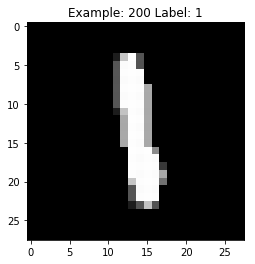

In [39]:
view_digit(X_train, y_train, 200)

In [40]:
# Model Architecture 
model = Sequential()

# Layers: 1, 2
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'))

# Pooling layer: 3
model.add(MaxPool2D(pool_size=(2,2))) # pooling layer
model.add(Dropout(0.25)) # dropout

# Layers: 4, 5
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))

# Pooling layer: 6
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25)) # dropout

# Flatten images
model.add(Flatten())

# Layers: 6, 7 (with dropout in between)
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax')) # makes prediction | last layer

In [41]:
# Model Compiling: Optimizer, Loss, Metrics
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [43]:
# Training
history = model.fit(X_train_keras, y_train_keras, validation_data=(X_validation_keras, y_validation_keras), epochs=3)

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 285s 6ms/step - loss: 0.0615 - acc: 0.9818 - val_loss: 0.0342 - val_acc: 0.9898
Epoch 2/3
50000/50000 [==============================] - 321s 6ms/step - loss: 0.0472 - acc: 0.9860 - val_loss: 0.0346 - val_acc: 0.9903
Epoch 3/3
50000/50000 [==============================] - 332s 7ms/step - loss: 0.0420 - acc: 0.9865 - val_loss: 0.0286 - val_acc: 0.9923


In [50]:
# Final accuracy
print(f"{history.history['acc'][-1] * 100}%")

98.646%


## DCGANs Revisited
We will build a generative model to product synthetic MNIST images that are very similar to the original MNIST ones. 

To produce near-realistic yet synthetic images, we need to train a generator that generates new images from the original MNIST images and a discriminator that judges whether those images are believably similar to the original ones or not. 

The original MNIST dataset represents the original data distribution. The generator learns from this original distribution and generates new images based off what it has learned, and the discrimintor attempts to determine whether the newly generated images are virtually indistinguable from the original distribution or not. 

The basic architecture of the **DCGAN Generator** is as follows:
The generator takes in an initial *noise vector* (100 x 1), and then projects and reshapes it into a (1024 x 4 x 4) tensor. 

This *project and reshape* action is the opposite of convolution and is known as *transposed convolution or deconvolution*. In transposed convolution, the original process of convolution is reversed, mapping a reduced tensor into a larger one. 

Here are the various stages:
```(100, 1) --> (1024, 4, 4) --> (512, 8, 8) --> (256, 16, 16) --> (128, 32, 32) --> (64, 64, 3)```

We will create a class ```DCGAN``` which we will use to build the generator, discriminator, discriminator model, and adversarial model. 

In [64]:
# DCGAN Class
class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):
        """
        MNIST: (28,28,1) images. That is they are 28 x 28 with only one color
        """
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None  # Discriminator
        self.G = None  # Generator
        self.AM = None # Adversarial Model
        self.DM = None # Discriminator Model
        
    def generator(self, depth=256, dim=7, dropout=0.3, momentum=0.8, window=5, input_dim=100, output_depth=1):
        """
        We are initiliazing our generator based on DCGANs defaults.
        (100,1) -> (7,7,256) -> (14,14,128) -> (28,28,64) -> (28,28,32) -> (28,28,1)
        """
        if self.G:
            return self.G
        
        # Initializing
        self.G = Sequential()
        
        # Layer 1 
        self.G.add(Dense(dim*dim*depth, input_dim=input_dim))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth))) # tensor
        self.G.add(Dropout(dropout))
        
        # Upsampling and transposed convolution - 3 times
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), window, padding="same"))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))
        
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), window, padding="same"))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))
        
        self.G.add(Conv2DTranspose(int(depth/8), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))
        
        # Final Layer to output
        self.G.add(Conv2DTranspose(output_depth, window, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        
        return self.G
    
    def discriminator(self, depth=64, dropout=0.3, alpha=0.3):
        if self.D:
            return self.D
        
        # instantiating the discrimnator model
        self.D = Sequential()
        
        # Initializing our input shape
        input_shape = (self.img_rows, self.img_cols, self.channel)
        
        # LAYERS
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))
        
        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))
        
        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))
        
        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))
        
        # Final dense layer 
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        
        return self.D
    
    
    def discriminator_model(self):
        """
        The police detecting the fake
        """
        if self.DM:
            return self.DM
        
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator()) # calling D
        self.DM.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return self.DM
    
    def adversarial_model(self):
        """
        The counterfeiter
        """
        if self.AM:
            return self.AM
        
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return self.AM

In [80]:
# DCGAN for MNIST
class MNIST_DCGAN(object):
    def __init__(self, x_train):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1
        self.x_train = x_train # input data
        
        # instantiating models
        self.DCGAN = DCGAN()
        self.discriminator = self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()
        
    # Training method
    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        
        if save_interval > 0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
            
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0, self.x_train.shape[0], size=batch_size), :, :, :]
            
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            
            images_fake = self.generator.predict(noise)
            
            x = np.concatenate([images_train, images_fake])
            y = np.ones([2 * batch_size, 1])
            y[batch_size:, :] = 0
            
            d_loss = self.discriminator.train_on_batch(x, y)
            
            y = np.ones([batch_size, 1])
            
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            
            a_loss = self.adversarial.train_on_batch(noise, y)
            
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], \
                                                      a_loss[1])
            
            print(log_mesg)
            if save_interval > 0:
                if (i + 1)%save_interval == 0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0], noise=noise_input, steps=(i+1))
                    
    # Plotting method
    def plot_images(self, save2file=False, fake=True, samples=16, \
                noise=None, step=0):
        current_path = os.getcwd()
        file = '/images/chapter12/synthetic_mnist/'
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(current_path+file+filename)
            plt.close('all')
        else:
            plt.show()

In [77]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time))

In [78]:
# Initializing MNIST DCGAN and train
mnist_dcgan = MNIST_DCGAN(X_train_keras)
# time = ElapsedTimer()
mnist_dcgan.train(train_steps=200, batch_size=256, save_interval=500)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 256)         819456    
__________

In [81]:
mnist_dcgan.plot_images(fake=True)

AttributeError: 'MNIST_DCGAN' object has no attribute 'plot_images'